# Spatial Clustering

Along with being able classify the different crystals within a configuration,
it is also really useful to know the size of the crystal,
which is particularly useful for an analysis of the melting rate.
After the classification,
we need to perform a spatial clustering of the crystals,
segmenting the configuration into a bulk liquid and bulk crystal region.
The spatial properties of the bulk crystal region can then be ascertained
by calculating a Convex Hull.

## Environment Setup

The classification and clustering of molecules
will be performed using the scikit-learn library `sklearn`,
while the Convex Hull is from the Scipy library.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import joblib
from sklearn import cluster
from scipy.spatial import ConvexHull
from sdanalysis.order import relative_orientations
from sdanalysis.figures import plot_frame

# Import project tools
import sys

sys.path.append("../src")
from trimer import read_file, neighbour_connectivity
from figures import plot_snapshots, plot_clustering

# Load trained K-Nearest Neighbours ML model
knn = joblib.load("../models/knn-trimer.pkl")

# Configure Bokeh to output the figures to the notebook
from bokeh.io import output_notebook, show

output_notebook()

Loading BokehJS ...

With the libraries loaded,
we can now read in the input files into the variable `snaps`.
I am only using a single input file for testing,
taking the final configuration of the p2 crystal
at a temperature of 0.45.
This configuration was chosen for being more representative of
the melting configurations which will be used to calculate the melting rate.

In [2]:
crystals = ["p2", "p2gg", "pg"]

snaps = []
for crystal in crystals:
    snaps.append(read_file(index=9, temperature=0.50, pressure=1.0, crystal=crystal,))

This chosen configuration is shown in the image below,
which has a much smaller volume of crystal
than previously studied configurations.

In [3]:
show(plot_snapshots(snaps))

## Classification

Before performing a spatial clustering of the crystalline regions
we first need to find the molecules which are considered crystalline.
This can be done using the `knn` model we developed in
[03_Supervised_Classification](03_Supervised_Classification.ipynb),
using the relative orientations for the features.

In [4]:
orientations = np.sort(
    np.concatenate(
        [relative_orientations(s.box, s.position, s.orientation) for s in snaps]
    ),
    axis=1,
)
classes = np.split(knn.predict(orientations), len(snaps))

When plotting the result of this classification in the image below
there are a number of singular 'false positives' within the liquid.
These molecules which are isolated in the liquid
could have a local environment which is considered crystalline,
however for the purposes of finding the area of the crystalline region
they should be ignored.

In [5]:
show(plot_clustering(knn, orientations, snaps, fit=False))

In [6]:
show(plot_frame(snaps[1], order_list=classes[1]))

In [ ]:
from bokeh.models import Range1d
from bokeh.io import export_svgs


def export_figure(snapshot, classification, crystal):
    plot = plot_frame(snapshot, order_list=classification)
    plot.axis.visible = False
    plot.xgrid.visible = False
    plot.ygrid.visible = False
    plot.toolbar_location = None
    plot.toolbar.logo = None
    plot.aspect_scale = 1.0
    plot.output_backend = "svg"
    export_svgs(plot, f"trimer-cat-{crystal}.svg")
    return plot

In [8]:
for snapshot, c, crystal in zip(snaps, classes, crystals):
    show(plot_frame(snapshot, order_list=c))
    export_figure(snapshot, c, crystal)

## Spatial Clustering

There are a number of ways which we can perform the spatial clustering,
with the simplest being to use space as another feature.
This simplest implementation is not necessarily the most appropriate,
requiring tuning of the feature space
such that the change of position is comparable to
the change from liquid to crystal.

An alternative method is to use a Hierarchical Clustering algorithm,
which attempts to iteratively merge clusters.
The reason this method works is that we can define the connectivity,
that is the spatial properties,
separately from the data points we want to cluster on.

The model which turned out to be most successful was [Ward Clustering](https://en.wikipedia.org/wiki/Ward%27s_method)
which is implemented below.
Here we use the class of the crystal as the dataset for classification,
while the connectivity is defined by the nearest neighbours.

In [9]:
X = classes[0].reshape(-1, 1)
connectivity = neighbour_connectivity(snaps[0])
agg_clustering = cluster.AgglomerativeClustering(
    n_clusters=2, connectivity=connectivity, linkage="ward"
)
y = agg_clustering.fit_predict(X)

The resulting cluster is shown in the image below,
which only has a single large crystalline region
suitable for calculating the area using the Convex Hull.

In [10]:
show(plot_frame(snaps[0], order_list=y, categorical_colour=True))

## Calculation of Area

The main reason for performing the spatial clustering
is the subsequent analysis of the cluster with a Convex Hull.
This analysis can be done using the [ConvexHull](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.ConvexHull.html)
class from the Scipy library
which just requires the positions of each of the points,
in this case only the points which
the spatial clustering considered crystalline.
The points for this simulation are all in two dimensions
yet they are represented by points in three dimensions.
So that ConvexHull computes a 2D convex hull
the positions are reduced to two dimensions.

In [11]:
snap = snaps[0]
crystal_points = snap.position[y == 1, :2]
hull = ConvexHull(crystal_points)

Once we have initialised the ConvexHull class,
the volume and the area are properties of the instance
and are easily accessed as below.

In [12]:
print(f"Volume: {hull.volume: >8.2f}\nArea  : {hull.area: >8.2f}")

Volume:  9979.22
Area  :   390.93


## Testing of Robustness

The goal of the spatial clustering is to
analyse every configuration in a trajectory
to measure the melting rate of the crystal.
For this purpose the classification of the crystal region
needs to be robust and work in all kinds of scenarios.
As a test for this I will be using
all the configurations in the trajectories I have
ensuring that the progression of melting occurs in a reasonable manner.

In [13]:
all_hulls = []
import gsd.hoomd
from sdanalysis import HoomdFrame

with gsd.hoomd.open(
    "../data/simulation/dataset/output/dump-Trimer-P1.00-T0.40-p2.gsd"
) as trj:
    for frame in trj:
        snap = HoomdFrame(frame)
        orientations = relative_orientations(snap.box, snap.position, snap.orientation)
        classes = knn.predict(orientations)
        connectivity = neighbour_connectivity(snap)
        agg_clustering = cluster.AgglomerativeClustering(
            n_clusters=2, connectivity=connectivity, linkage="ward"
        )
        y = agg_clustering.fit_predict(classes.reshape(-1, 1))
        crystal_points = snap.position[y == 1, :2]
        if len(crystal_points > 3):
            hull = ConvexHull(crystal_points)
            all_hulls.append(hull)

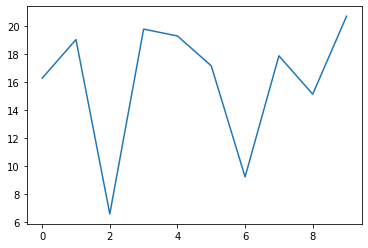

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot([hull.volume for hull in all_hulls])

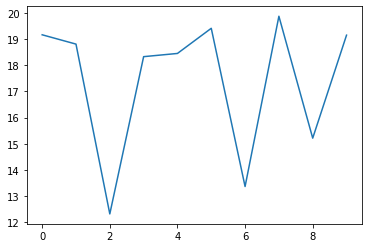

In [15]:
plt.plot([hull.area for hull in all_hulls])

## Demonstrating Effiectiveness throughout simulation